# IAU Projekt

# Fáza 2 - predspracovanie údajov

V tejto fáze sa od Vás očakáva:
* Realizujte predspracovanie údajov pre strojové učenie. Výsledkom bude upravená dátová sada vo formáte csv alebo tsv, kde jedno pozorovanie musí byť opísané jedným riadkom.
* V 3. fáze budeme pracovať s algoritmami strojového učenia, ktorých implementácia v scikit-learn podporuje len numerické dáta. To vedie k tomu že treba niečo spraviť s nenumerickými dátami.
* Replikovateľnosť predspracovania na trénovacej a testovacej množine dát.

Keď sa predspracovaním mohol zmeniť tvar a charakteristiky dát (počet atribútov, distribúcie hodnôt a pod.), je možné že treba znovu zrealizovať podstatné časti prieskumnej analýzy a opakovane podľa Vašej potreby. Bodovanie znovu za EDA už nebudeme, zmeny ale zdokumentujte. Problém s dátami môžete riešiť iteratívne v každej fáze aj vo všetkých fázach podľa vlastnej potreby.


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats as sm_stats

import datetime
import category_encoders as ce
from sklearn.impute import SimpleImputer, KNNImputer
from numpy import percentile

In [2]:
def frombirthtoage(born):
    now = datetime.date.today()
    return now.year - born.year - ((now.month, now.day) < (born.month, born.day))

In [3]:
labor = pd.read_csv("046/labor.csv", sep='\t')
labor.rename(columns = {"Unnamed: 0": "index"}, inplace = True)
labor = labor.drop(["index", "name"], axis=1)
smoker_encoding = {"Y": 1, "N": 0, "yes": 1, "no": 0}
labor["smoker"].replace(smoker_encoding, inplace=True)
ce_ordinal_labor = ce.OrdinalEncoder(cols=["relationship"])
labor = ce_ordinal_labor.fit_transform(labor)

profiles = pd.read_csv("046/profiles.csv", sep='\t')
profiles.rename(columns = {"Unnamed: 0": "index"}, inplace = True)
profiles["race"].replace({"black": "Black", "white": "White", "blsck": "Black"}, inplace=True)
profiles["birthdate"] = pd.to_datetime(profiles['birthdate'], utc=False)
ce_ordinal_profiles = ce.OrdinalEncoder(cols=["race", "blood_group", "sex"])
profiles = ce_ordinal_profiles.fit_transform(profiles)
ages = profiles['birthdate'].apply(lambda d: frombirthtoage(d))
profiles = profiles.assign(age=ages.values)
profiles = profiles.drop(["residence", "job", "company", "name", "birthdate"], axis=1)

merged = pd.merge(profiles, labor, how='outer', on='ssn')
merged = merged.drop(["ssn"], axis=1)


C:\Users\PeterSmrecek\Documents\IAU-repository\IAU-virtual\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [4]:
merged.head()

,index,race,blood_group,sex,age,weight,hemoglobin,alp,etytr,alt,erytrocyty,hbver,hematokrit,indicator,er-cv,leukocyty,smoker,relationship,ast,trombocyty
0,0,1,1,1,14,68.64852,7.26815,68.18352,5.81889,2.66285,6.93051,6.07205,11.27999,0.0,44.47642,8.86713,0,1,26.77151,5.62532
1,0,1,1,1,14,39.27363,5.09400,58.42059,5.99564,1.43578,6.54612,9.31958,11.65206,1.0,57.12059,10.57140,0,2,38.28069,6.59275
2,0,1,1,1,14,61.21115,9.10298,14.51194,10.27253,2.13866,6.91541,5.98328,9.13539,1.0,16.95110,7.30150,0,4,52.93857,8.58363
3,0,1,1,1,14,121.34568,9.03854,11.04396,5.55113,1.35987,6.49755,6.91512,8.46192,0.0,63.86999,8.47060,0,4,48.94005,7.28386
4,1,2,2,1,50,107.36307,7.43673,68.85609,5.90077,3.45904,7.88035,7.00488,5.96198,1.0,42.66862,6.25355,0,3,60.53571,9.03697


## 1. Integrácia a čistenie dát (5b)

Transformujte dáta na vhodný formát pre strojové učenie t.j. jedno pozorovanie musí byť opísané jedným riadkom a každý atribút musí byť v numerickom formáte. 
* Pri riešení chýbajúcich hodnôt (missing values) vyskúšajte rôzne stratégie z nasledujúcich podskupín:
    * odstránenie pozorovaní s chýbajúcimi údajmi
    * nahradenie chýbajúcej hodnoty mediánom, priemerom, pomerom (ku korelovanému atribútu), alebo pomocou lineárnej regresie resp. kNN
* Podobne postupujte aj pri riešení vychýlených hodnôt (outlier detection):
    * odstránenie vychýlených (odľahlých) pozorovaní
    * nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5% resp. 95%)

### Chýbajúce dáta

In [5]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10002 entries, 0 to 10001
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         10002 non-null  int64  
 1   race          10002 non-null  int32  
 2   blood_group   10002 non-null  int32  
 3   sex           10002 non-null  int32  
 4   age           10002 non-null  int64  
 5   weight        10002 non-null  float64
 6   hemoglobin    9972 non-null   float64
 7   alp           9972 non-null   float64
 8   etytr         9972 non-null   float64
 9   alt           9971 non-null   float64
 10  erytrocyty    9972 non-null   float64
 11  hbver         9972 non-null   float64
 12  hematokrit    9972 non-null   float64
 13  indicator     10002 non-null  float64
 14  er-cv         9972 non-null   float64
 15  leukocyty     9972 non-null   float64
 16  smoker        10002 non-null  int64  
 17  relationship  10002 non-null  int32  
 18  ast           9972 non-nul

In [6]:
merged.shape[0] - merged.dropna().shape[0]

330

In [7]:
merged.isnull().sum()

index            0
race             0
blood_group      0
sex              0
age              0
weight           0
hemoglobin      30
alp             30
etytr           30
alt             31
erytrocyty      30
hbver           30
hematokrit      30
indicator        0
er-cv           30
leukocyty       30
smoker           0
relationship     0
ast             30
trombocyty      30
dtype: int64

In [8]:
merged.isnull().sum().sum()

331

In [9]:
print("Chýbajúce dáta tvoria {:.3f}% dát".format(merged.isnull().sum().sum() / merged.shape[0] * 100))

Chýbajúce dáta tvoria 3.309% dát


#### Odstránenie pozorovaní s chýbajúcimi údajmi

In [10]:
merged_withoutNA = merged.dropna()

In [11]:
merged_withoutNA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9672 entries, 0 to 10001
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         9672 non-null   int64  
 1   race          9672 non-null   int32  
 2   blood_group   9672 non-null   int32  
 3   sex           9672 non-null   int32  
 4   age           9672 non-null   int64  
 5   weight        9672 non-null   float64
 6   hemoglobin    9672 non-null   float64
 7   alp           9672 non-null   float64
 8   etytr         9672 non-null   float64
 9   alt           9672 non-null   float64
 10  erytrocyty    9672 non-null   float64
 11  hbver         9672 non-null   float64
 12  hematokrit    9672 non-null   float64
 13  indicator     9672 non-null   float64
 14  er-cv         9672 non-null   float64
 15  leukocyty     9672 non-null   float64
 16  smoker        9672 non-null   int64  
 17  relationship  9672 non-null   int32  
 18  ast           9672 non-null

<AxesSubplot:>

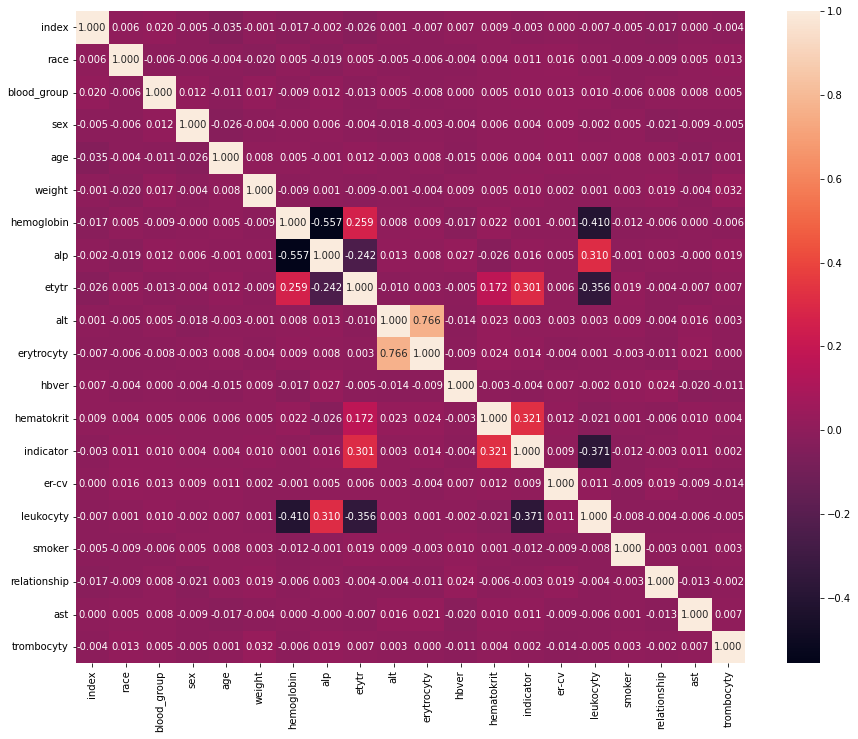

In [12]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(merged.corr(), ax=ax, annot=True, fmt=".3f")

<AxesSubplot:>

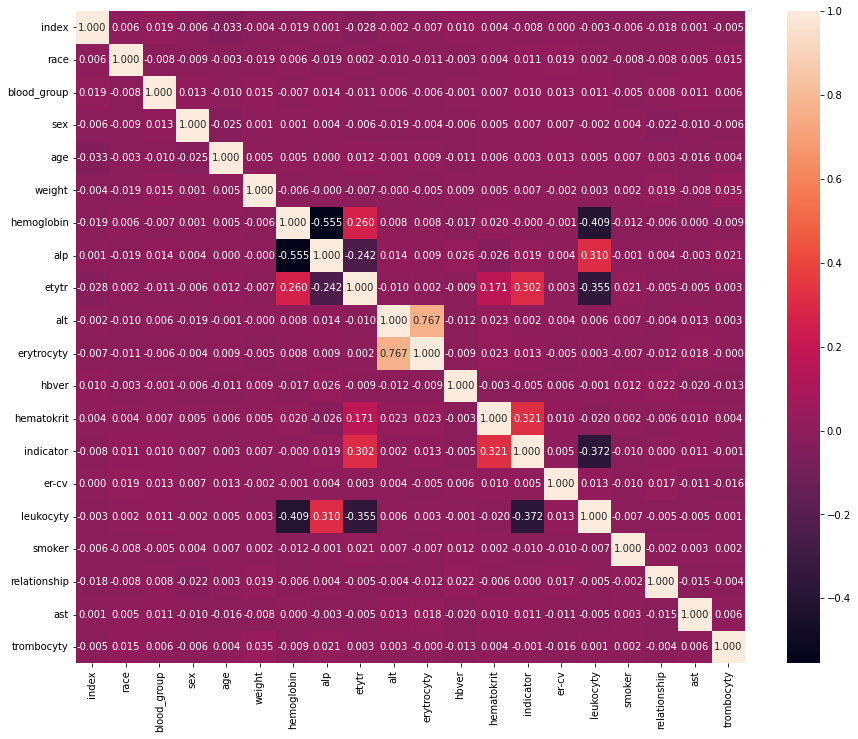

In [13]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(merged_withoutNA.corr(), ax=ax, annot=True, fmt=".3f")

Po odstránení chýbajúcich hodnôt sa nič významné nezmienilo

#### Nahradenie chýbajúcej hodnoty mediánom, priemerom, pomerom (ku korelovanému atribútu), alebo pomocou lineárnej regresie resp. kNN

In [14]:
na_cols = ["hemoglobin", "alp", "etytr", "alt", "erytrocyty", "hbver", "hematokrit", "er-cv", "leukocyty", "ast", "trombocyty"] 

In [15]:
# def sex_diff(col):
#     print("M ", col, ": ", merged[merged["sex"] == 0][col].mean())
#     print("F ", col, ": ", merged[merged["sex"] == 1][col].mean())

# for col in na_cols: sex_diff(col)

In [16]:
def replaceNaN(original_merged, strategy, na_cols):
    new_merged = original_merged.copy()
    if strategy == "kNN":
        imp_strategy = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
    elif strategy == "mean" or strategy == "median":    
        imp_strategy = SimpleImputer(missing_values=np.nan, strategy=strategy)
    else:
        raise Exception("Chybny argument strategy")
    for col in na_cols:
        new_merged[col] = imp_strategy.fit_transform(new_merged[[col]])
    return new_merged
    

##### Nahradenie priemerom

In [17]:
merged_mean = replaceNaN(merged, "mean", na_cols)
merged_mean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10002 entries, 0 to 10001
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         10002 non-null  int64  
 1   race          10002 non-null  int32  
 2   blood_group   10002 non-null  int32  
 3   sex           10002 non-null  int32  
 4   age           10002 non-null  int64  
 5   weight        10002 non-null  float64
 6   hemoglobin    10002 non-null  float64
 7   alp           10002 non-null  float64
 8   etytr         10002 non-null  float64
 9   alt           10002 non-null  float64
 10  erytrocyty    10002 non-null  float64
 11  hbver         10002 non-null  float64
 12  hematokrit    10002 non-null  float64
 13  indicator     10002 non-null  float64
 14  er-cv         10002 non-null  float64
 15  leukocyty     10002 non-null  float64
 16  smoker        10002 non-null  int64  
 17  relationship  10002 non-null  int32  
 18  ast           10002 non-nu

<AxesSubplot:>

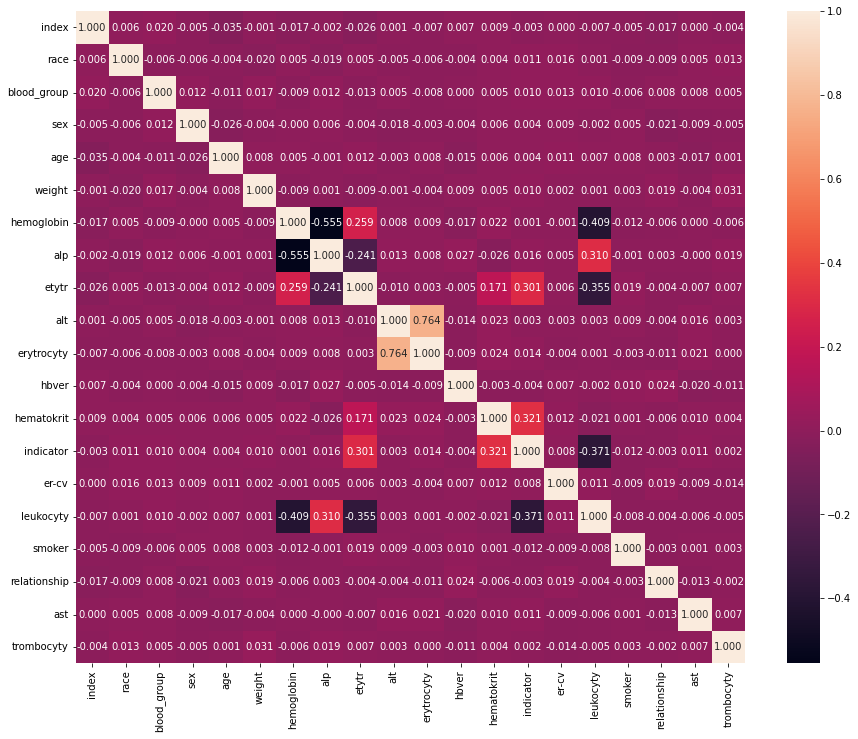

In [18]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(merged_mean.corr(), ax=ax, annot=True, fmt=".3f")

##### Nahradenie mediánom

In [19]:
merged_median = replaceNaN(merged, "median", na_cols)
merged_median.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10002 entries, 0 to 10001
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         10002 non-null  int64  
 1   race          10002 non-null  int32  
 2   blood_group   10002 non-null  int32  
 3   sex           10002 non-null  int32  
 4   age           10002 non-null  int64  
 5   weight        10002 non-null  float64
 6   hemoglobin    10002 non-null  float64
 7   alp           10002 non-null  float64
 8   etytr         10002 non-null  float64
 9   alt           10002 non-null  float64
 10  erytrocyty    10002 non-null  float64
 11  hbver         10002 non-null  float64
 12  hematokrit    10002 non-null  float64
 13  indicator     10002 non-null  float64
 14  er-cv         10002 non-null  float64
 15  leukocyty     10002 non-null  float64
 16  smoker        10002 non-null  int64  
 17  relationship  10002 non-null  int32  
 18  ast           10002 non-nu

<AxesSubplot:>

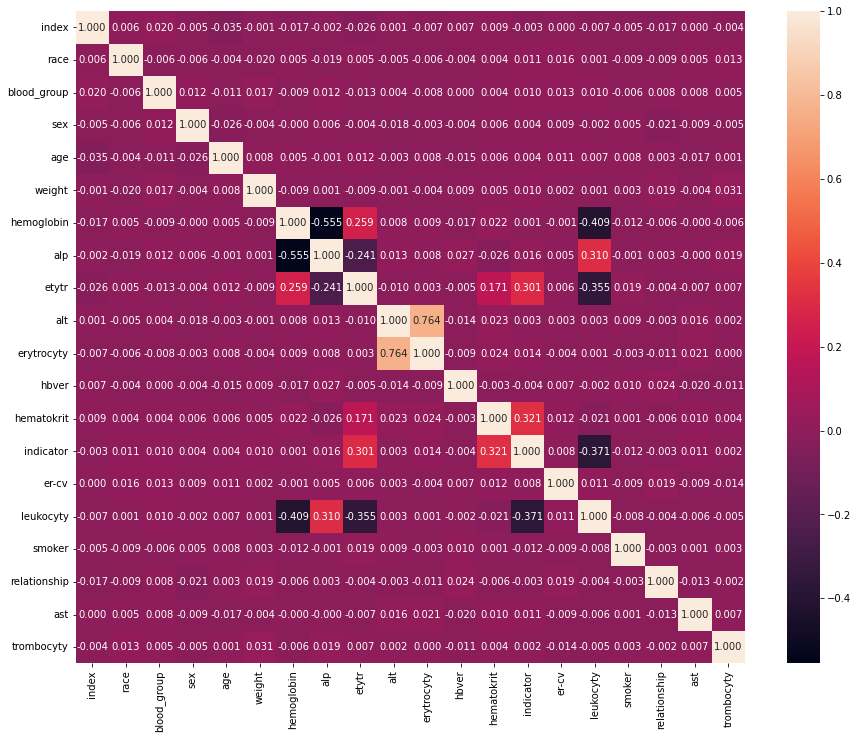

In [20]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(merged_median.corr(), ax=ax, annot=True, fmt=".3f")

##### Nahradenie kNN

In [21]:
merged_knn = replaceNaN(merged, "mean", na_cols)
merged_knn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10002 entries, 0 to 10001
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         10002 non-null  int64  
 1   race          10002 non-null  int32  
 2   blood_group   10002 non-null  int32  
 3   sex           10002 non-null  int32  
 4   age           10002 non-null  int64  
 5   weight        10002 non-null  float64
 6   hemoglobin    10002 non-null  float64
 7   alp           10002 non-null  float64
 8   etytr         10002 non-null  float64
 9   alt           10002 non-null  float64
 10  erytrocyty    10002 non-null  float64
 11  hbver         10002 non-null  float64
 12  hematokrit    10002 non-null  float64
 13  indicator     10002 non-null  float64
 14  er-cv         10002 non-null  float64
 15  leukocyty     10002 non-null  float64
 16  smoker        10002 non-null  int64  
 17  relationship  10002 non-null  int32  
 18  ast           10002 non-nu

<AxesSubplot:>

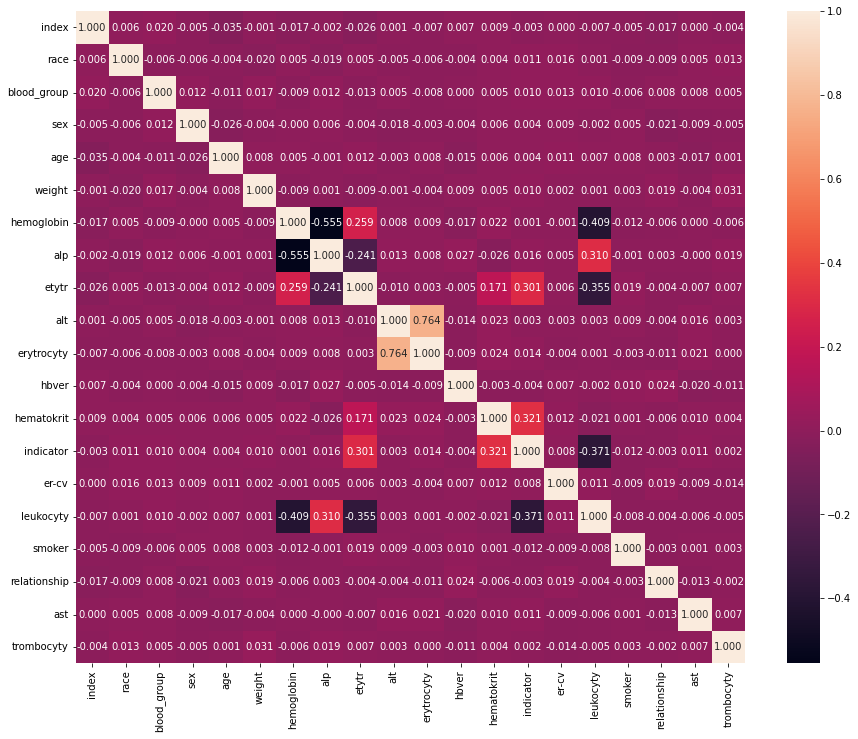

In [22]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(merged_knn.corr(), ax=ax, annot=True, fmt=".3f")

In [23]:
merged_mean.corr() - merged_median.corr()

,index,race,blood_group,sex,age,weight,hemoglobin,alp,etytr,alt,erytrocyty,hbver,hematokrit,indicator,er-cv,leukocyty,smoker,relationship,ast,trombocyty
index,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.309927e-05,-0.000006,-6.112278e-06,0.000103,-7.590960e-07,-1.881490e-07,-0.000022,0.000000e+00,6.184470e-07,0.000116,0.000000e+00,0.000000e+00,8.451716e-07,1.143090e-06
race,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.738929e-05,-0.000023,-1.375642e-06,-0.000094,3.882981e-06,6.911578e-07,-0.000048,0.000000e+00,-1.995276e-06,0.000107,0.000000e+00,0.000000e+00,-3.493862e-06,-4.252607e-07
blood_group,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.102259e-05,-0.000016,-3.656487e-06,0.000106,-1.818350e-06,-8.554363e-07,0.000034,0.000000e+00,-1.819620e-06,-0.000070,0.000000e+00,0.000000e+00,-3.290237e-06,-3.813291e-07
sex,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.229058e-06,-0.000027,5.841383e-06,0.000155,3.102235e-06,6.416648e-07,-0.000002,0.000000e+00,4.711496e-07,-0.000058,0.000000e+00,0.000000e+00,4.265989e-06,-2.167064e-07
age,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.084716e-05,0.000014,-1.387837e-06,0.000321,-2.231649e-06,6.176123e-07,0.000006,0.000000e+00,2.318439e-07,-0.000019,0.000000e+00,0.000000e+00,4.302909e-06,5.018084e-07
weight,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.202691e-06,0.000002,-4.009885e-06,0.000295,1.554878e-06,6.630011e-07,-0.000007,0.000000e+00,1.326511e-06,-0.000107,0.000000e+00,0.000000e+00,-1.785412e-06,-7.557277e-07
hemoglobin,1.309927e-05,3.738929e-05,2.102259e-05,-2.229058e-06,-2.084716e-05,1.202691e-06,0.000000e+00,0.000012,-1.187615e-05,0.000190,-2.466474e-05,-3.460956e-05,-0.000051,-2.942349e-05,2.852346e-05,-0.000054,-3.133367e-05,9.577964e-06,2.862227e-05,6.943692e-07
alp,-6.056316e-06,-2.328802e-05,-1.603580e-05,-2.685806e-05,1.373022e-05,2.156200e-06,1.220455e-05,0.000000,1.879684e-05,-0.000240,-9.477205e-06,-8.609679e-06,-0.000015,-3.155563e-05,-4.514591e-05,0.000006,2.152900e-05,-1.273872e-05,-4.938794e-06,-2.882502e-06
etytr,-6.112278e-06,-1.375642e-06,-3.656487e-06,5.841383e-06,-1.387837e-06,-4.009885e-06,-1.187615e-05,0.000019,0.000000e+00,-0.000012,-9.329813e-06,9.841510e-07,0.000010,-4.376556e-06,7.398149e-06,-0.000179,4.513961e-08,1.436509e-06,-1.263523e-05,1.556074e-06
alt,1.025391e-04,-9.435332e-05,1.056895e-04,1.547290e-04,3.210397e-04,2.951931e-04,1.901618e-04,-0.000240,-1.196076e-05,0.000000,8.005797e-05,-2.272546e-04,0.000090,2.466538e-04,1.408327e-04,-0.000304,2.113607e-04,-1.606015e-04,2.085276e-04,1.234114e-04


In [24]:
merged_mean.corr() - merged_knn.corr()

,index,race,blood_group,sex,age,weight,hemoglobin,alp,etytr,alt,erytrocyty,hbver,hematokrit,indicator,er-cv,leukocyty,smoker,relationship,ast,trombocyty
index,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
race,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
blood_group,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sex,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
age,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
weight,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hemoglobin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
alp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
etytr,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
alt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
merged_median.corr() - merged_knn.corr()

,index,race,blood_group,sex,age,weight,hemoglobin,alp,etytr,alt,erytrocyty,hbver,hematokrit,indicator,er-cv,leukocyty,smoker,relationship,ast,trombocyty
index,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.309927e-05,0.000006,6.112278e-06,-0.000103,7.590960e-07,1.881490e-07,0.000022,0.000000e+00,-6.184470e-07,-0.000116,0.000000e+00,0.000000e+00,-8.451716e-07,-1.143090e-06
race,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.738929e-05,0.000023,1.375642e-06,0.000094,-3.882981e-06,-6.911578e-07,0.000048,0.000000e+00,1.995276e-06,-0.000107,0.000000e+00,0.000000e+00,3.493862e-06,4.252607e-07
blood_group,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.102259e-05,0.000016,3.656487e-06,-0.000106,1.818350e-06,8.554363e-07,-0.000034,0.000000e+00,1.819620e-06,0.000070,0.000000e+00,0.000000e+00,3.290237e-06,3.813291e-07
sex,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.229058e-06,0.000027,-5.841383e-06,-0.000155,-3.102235e-06,-6.416648e-07,0.000002,0.000000e+00,-4.711496e-07,0.000058,0.000000e+00,0.000000e+00,-4.265989e-06,2.167064e-07
age,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.084716e-05,-0.000014,1.387837e-06,-0.000321,2.231649e-06,-6.176123e-07,-0.000006,0.000000e+00,-2.318439e-07,0.000019,0.000000e+00,0.000000e+00,-4.302909e-06,-5.018084e-07
weight,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.202691e-06,-0.000002,4.009885e-06,-0.000295,-1.554878e-06,-6.630011e-07,0.000007,0.000000e+00,-1.326511e-06,0.000107,0.000000e+00,0.000000e+00,1.785412e-06,7.557277e-07
hemoglobin,-1.309927e-05,-3.738929e-05,-2.102259e-05,2.229058e-06,2.084716e-05,-1.202691e-06,0.000000e+00,-0.000012,1.187615e-05,-0.000190,2.466474e-05,3.460956e-05,0.000051,2.942349e-05,-2.852346e-05,0.000054,3.133367e-05,-9.577964e-06,-2.862227e-05,-6.943692e-07
alp,6.056316e-06,2.328802e-05,1.603580e-05,2.685806e-05,-1.373022e-05,-2.156200e-06,-1.220455e-05,0.000000,-1.879684e-05,0.000240,9.477205e-06,8.609679e-06,0.000015,3.155563e-05,4.514591e-05,-0.000006,-2.152900e-05,1.273872e-05,4.938794e-06,2.882502e-06
etytr,6.112278e-06,1.375642e-06,3.656487e-06,-5.841383e-06,1.387837e-06,4.009885e-06,1.187615e-05,-0.000019,0.000000e+00,0.000012,9.329813e-06,-9.841510e-07,-0.000010,4.376556e-06,-7.398149e-06,0.000179,-4.513961e-08,-1.436509e-06,1.263523e-05,-1.556074e-06
alt,-1.025391e-04,9.435332e-05,-1.056895e-04,-1.547290e-04,-3.210397e-04,-2.951931e-04,-1.901618e-04,0.000240,1.196076e-05,0.000000,-8.005797e-05,2.272546e-04,-0.000090,-2.466538e-04,-1.408327e-04,0.000304,-2.113607e-04,1.606015e-04,-2.085276e-04,-1.234114e-04


### Vychýlené dáta

index              AxesSubplot(0.125,0.787927;0.227941x0.0920732)
race            AxesSubplot(0.398529,0.787927;0.227941x0.0920732)
blood_group     AxesSubplot(0.672059,0.787927;0.227941x0.0920732)
sex                AxesSubplot(0.125,0.677439;0.227941x0.0920732)
age             AxesSubplot(0.398529,0.677439;0.227941x0.0920732)
weight          AxesSubplot(0.672059,0.677439;0.227941x0.0920732)
hemoglobin         AxesSubplot(0.125,0.566951;0.227941x0.0920732)
alp             AxesSubplot(0.398529,0.566951;0.227941x0.0920732)
etytr           AxesSubplot(0.672059,0.566951;0.227941x0.0920732)
alt                AxesSubplot(0.125,0.456463;0.227941x0.0920732)
erytrocyty      AxesSubplot(0.398529,0.456463;0.227941x0.0920732)
hbver           AxesSubplot(0.672059,0.456463;0.227941x0.0920732)
hematokrit         AxesSubplot(0.125,0.345976;0.227941x0.0920732)
indicator       AxesSubplot(0.398529,0.345976;0.227941x0.0920732)
er-cv           AxesSubplot(0.672059,0.345976;0.227941x0.0920732)
leukocyty 

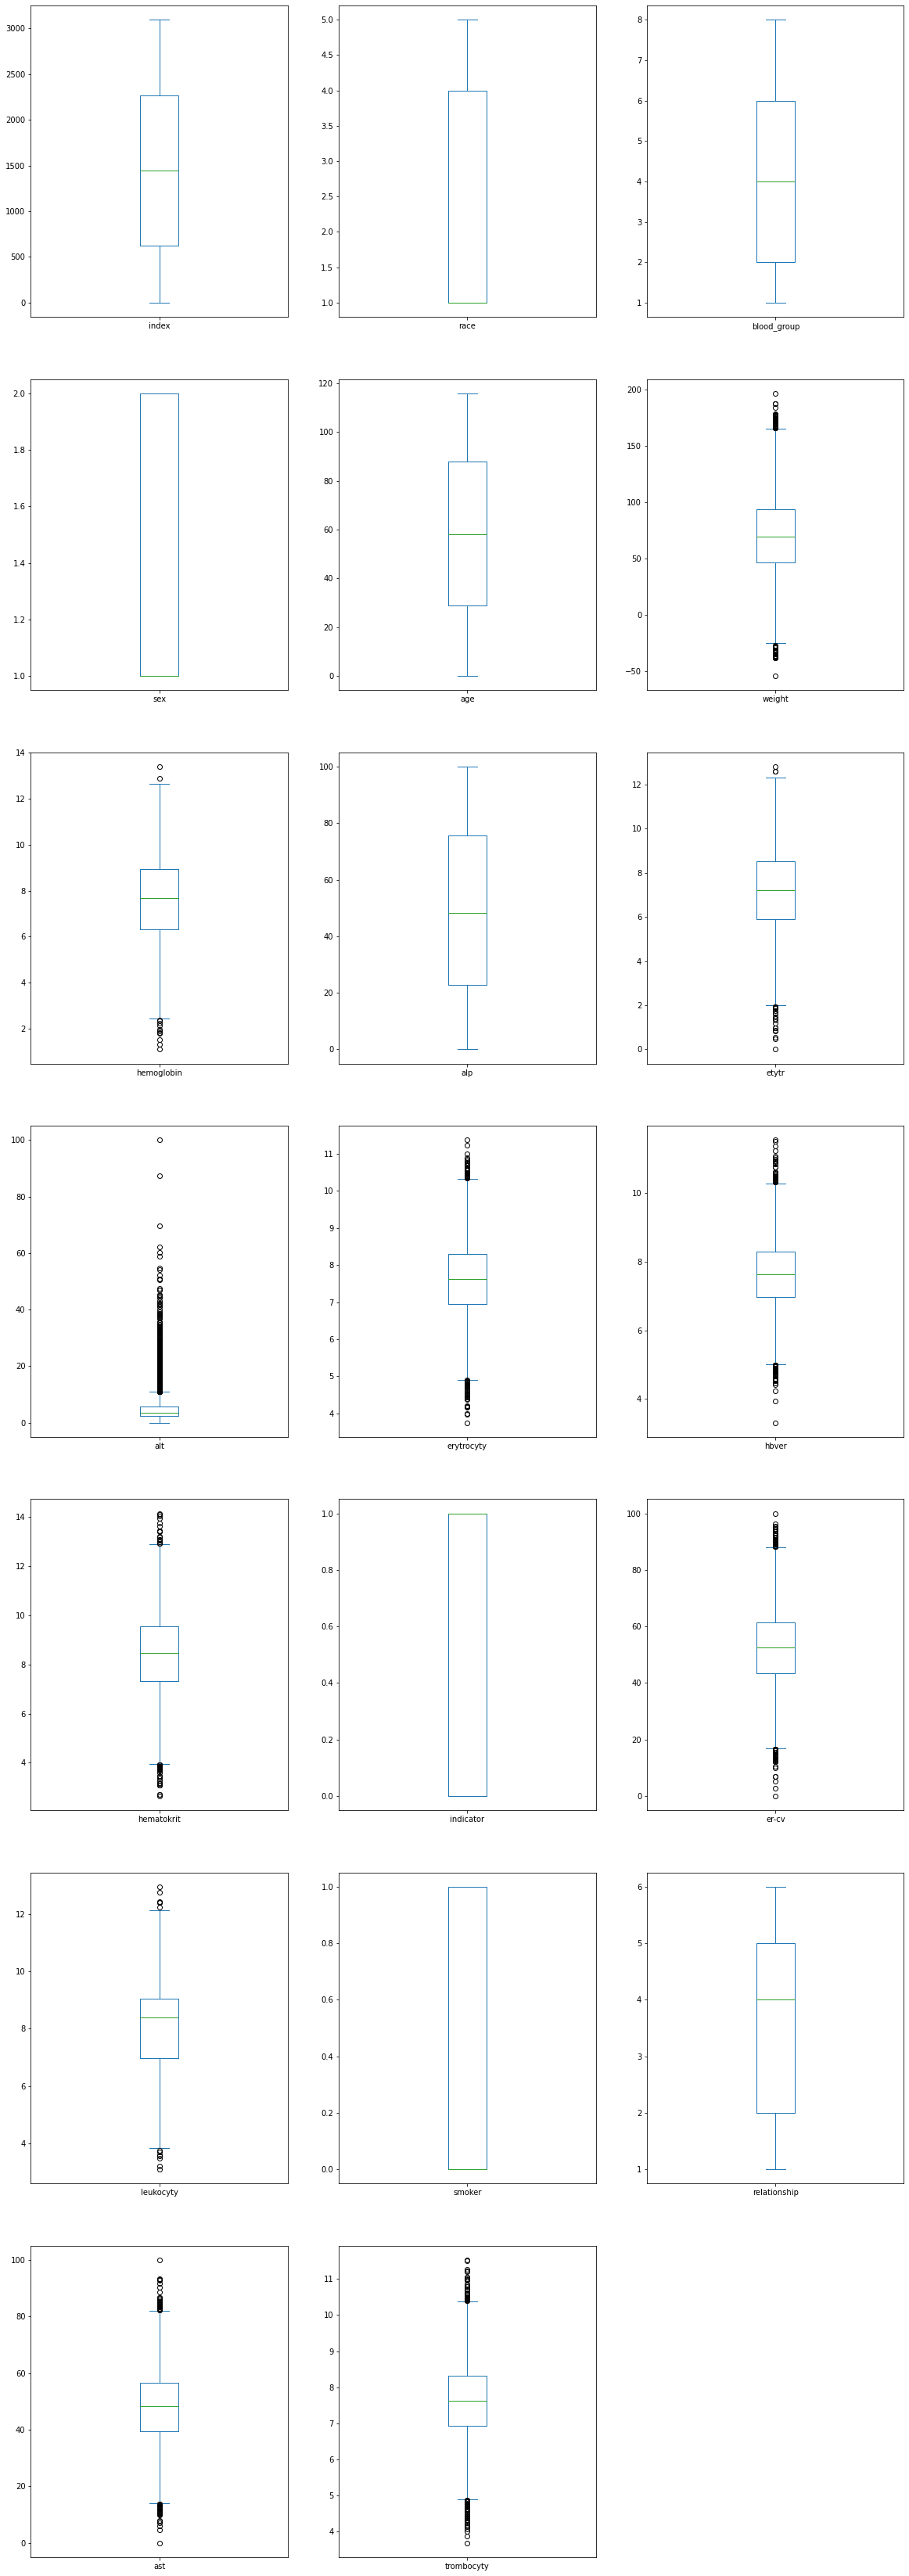

In [26]:
merged.plot(kind='box', subplots=True, layout=(7, 3), sharex=False, sharey=False, figsize=(20, 60))

#### Identifikácia vychýlených hodnôt

In [27]:
def identify_outliers(merged):
    suma = 0;
    for col in merged.columns:
        q25, q75 = percentile(merged[col], 25), percentile(merged[col], 75)
        iqr = q75 - q25
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        outliers = merged[((merged[col] < lower) | (merged[col] > upper))] 
        print(col, 'Identified outliers: %d' % len(outliers))
        suma += len(outliers)
    print('Sum of identified outliers: %d' % suma)

In [28]:
identify_outliers(merged_mean)

index Identified outliers: 0
race Identified outliers: 0
blood_group Identified outliers: 0
sex Identified outliers: 0
age Identified outliers: 0
weight Identified outliers: 60
hemoglobin Identified outliers: 13
alp Identified outliers: 0
etytr Identified outliers: 23
alt Identified outliers: 799
erytrocyty Identified outliers: 75
hbver Identified outliers: 77
hematokrit Identified outliers: 49
indicator Identified outliers: 0
er-cv Identified outliers: 69
leukocyty Identified outliers: 16
smoker Identified outliers: 0
relationship Identified outliers: 0
ast Identified outliers: 58
trombocyty Identified outliers: 76
Sum of identified outliers: 1315


#### Odstránenie vychýlených (odľahlých) pozorovaní

In [29]:
def remove_outliers(merged):
    newMerged = merged.copy()
    for col in newMerged.columns:
        q25, q75 = percentile(newMerged[col], 25), percentile(newMerged[col], 75)
        iqr = q75 - q25
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        newMerged = newMerged[((newMerged[col] >= lower) & (newMerged[col] <= upper))] 
    return newMerged

In [30]:
merged_mean_withoutOut = remove_outliers(merged_mean)
merged_mean_withoutOut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 0 to 10001
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         8760 non-null   int64  
 1   race          8760 non-null   int32  
 2   blood_group   8760 non-null   int32  
 3   sex           8760 non-null   int32  
 4   age           8760 non-null   int64  
 5   weight        8760 non-null   float64
 6   hemoglobin    8760 non-null   float64
 7   alp           8760 non-null   float64
 8   etytr         8760 non-null   float64
 9   alt           8760 non-null   float64
 10  erytrocyty    8760 non-null   float64
 11  hbver         8760 non-null   float64
 12  hematokrit    8760 non-null   float64
 13  indicator     8760 non-null   float64
 14  er-cv         8760 non-null   float64
 15  leukocyty     8760 non-null   float64
 16  smoker        8760 non-null   int64  
 17  relationship  8760 non-null   int32  
 18  ast           8760 non-null

<AxesSubplot:>

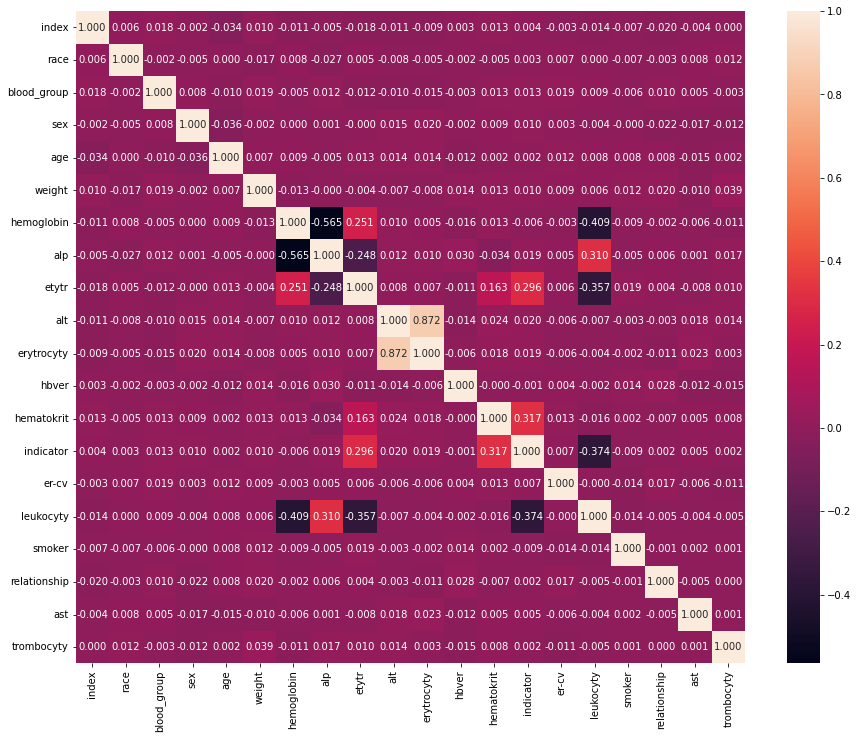

In [31]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(merged_mean_withoutOut.corr(), ax=ax, annot=True, fmt=".3f")

In [32]:
merged_mean.corr() - merged_mean_withoutOut.corr()

,index,race,blood_group,sex,age,weight,hemoglobin,alp,etytr,alt,erytrocyty,hbver,hematokrit,indicator,er-cv,leukocyty,smoker,relationship,ast,trombocyty
index,0.000000,-0.000291,0.001494,-0.003543,-0.001555,-0.011664,-0.006539,0.002689,-0.007166,0.011651,0.002242,0.004034,-0.004439,-0.007065,0.003465,0.006745,0.001649,0.003277,0.003898,-0.004209
race,-0.000291,0.000000,-0.003828,-0.001821,-0.003735,-0.003868,-0.002253,0.008338,-0.000767,0.002668,-0.001066,-0.001123,0.008977,0.008597,0.008157,0.000708,-0.002071,-0.005532,-0.002235,0.001755
blood_group,0.001494,-0.003828,0.000000,0.003757,-0.001947,-0.002267,-0.003778,0.000189,-0.001235,0.014330,0.006969,0.003632,-0.008034,-0.003088,-0.005848,0.001015,0.000717,-0.001363,0.003441,0.007978
sex,-0.003543,-0.001821,0.003757,0.000000,0.010184,-0.001363,-0.000644,0.004733,-0.003494,-0.033333,-0.023385,-0.002072,-0.003592,-0.005119,0.005502,0.002120,0.005602,0.001292,0.007617,0.006716
age,-0.001555,-0.003735,-0.001947,0.010184,0.000000,0.000923,-0.004085,0.004079,-0.000721,-0.017113,-0.005907,-0.003233,0.004475,0.002206,-0.000667,-0.000479,0.000739,-0.005579,-0.001126,-0.000532
weight,-0.011664,-0.003868,-0.002267,-0.001363,0.000923,0.000000,0.004329,0.001405,-0.004478,0.006178,0.003716,-0.005144,-0.007322,0.000192,-0.007124,-0.005184,-0.008915,-0.000522,0.006271,-0.007494
hemoglobin,-0.006539,-0.002253,-0.003778,-0.000644,-0.004085,0.004329,0.000000,0.009877,0.007609,-0.001927,0.004381,-0.001059,0.008899,0.007676,0.002365,-0.000352,-0.003719,-0.003924,0.005778,0.004518
alp,0.002689,0.008338,0.000189,0.004733,0.004079,0.001405,0.009877,0.000000,0.007330,0.000592,-0.002124,-0.002838,0.007865,-0.002560,0.000236,-0.000677,0.003519,-0.002581,-0.001006,0.001917
etytr,-0.007166,-0.000767,-0.001235,-0.003494,-0.000721,-0.004478,0.007609,0.007330,0.000000,-0.017626,-0.004629,0.005474,0.008364,0.004689,-0.000642,0.002592,-0.000154,-0.007690,0.000739,-0.002488
alt,0.011651,0.002668,0.014330,-0.033333,-0.017113,0.006178,-0.001927,0.000592,-0.017626,0.000000,-0.107976,-0.000366,-0.000921,-0.017001,0.009634,0.010018,0.012710,-0.000558,-0.001970,-0.011252


#### Nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5% resp. 95%)

In [33]:
def replace_outliers(merged):
    newMerged = merged.copy()
    for col in newMerged.columns:
        q05, q95 = percentile(newMerged[col], 5), percentile(newMerged[col], 95)
        newMerged[col] = np.where(newMerged[col] < q05, q05, newMerged[col])
        newMerged[col] = np.where(newMerged[col] > q95, q95, newMerged[col])
    return newMerged

In [34]:
merged_mean_replacedOut = replace_outliers(merged_mean)

In [35]:
merged_mean_replacedOut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10002 entries, 0 to 10001
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         10002 non-null  float64
 1   race          10002 non-null  float64
 2   blood_group   10002 non-null  float64
 3   sex           10002 non-null  float64
 4   age           10002 non-null  float64
 5   weight        10002 non-null  float64
 6   hemoglobin    10002 non-null  float64
 7   alp           10002 non-null  float64
 8   etytr         10002 non-null  float64
 9   alt           10002 non-null  float64
 10  erytrocyty    10002 non-null  float64
 11  hbver         10002 non-null  float64
 12  hematokrit    10002 non-null  float64
 13  indicator     10002 non-null  float64
 14  er-cv         10002 non-null  float64
 15  leukocyty     10002 non-null  float64
 16  smoker        10002 non-null  float64
 17  relationship  10002 non-null  float64
 18  ast           10002 non-nu

In [36]:
identify_outliers(merged_mean_replacedOut)

index Identified outliers: 0
race Identified outliers: 0
blood_group Identified outliers: 0
sex Identified outliers: 0
age Identified outliers: 0
weight Identified outliers: 0
hemoglobin Identified outliers: 0
alp Identified outliers: 0
etytr Identified outliers: 0
alt Identified outliers: 799
erytrocyty Identified outliers: 0
hbver Identified outliers: 0
hematokrit Identified outliers: 0
indicator Identified outliers: 0
er-cv Identified outliers: 0
leukocyty Identified outliers: 0
smoker Identified outliers: 0
relationship Identified outliers: 0
ast Identified outliers: 0
trombocyty Identified outliers: 0
Sum of identified outliers: 799


index              AxesSubplot(0.125,0.787927;0.227941x0.0920732)
race            AxesSubplot(0.398529,0.787927;0.227941x0.0920732)
blood_group     AxesSubplot(0.672059,0.787927;0.227941x0.0920732)
sex                AxesSubplot(0.125,0.677439;0.227941x0.0920732)
age             AxesSubplot(0.398529,0.677439;0.227941x0.0920732)
weight          AxesSubplot(0.672059,0.677439;0.227941x0.0920732)
hemoglobin         AxesSubplot(0.125,0.566951;0.227941x0.0920732)
alp             AxesSubplot(0.398529,0.566951;0.227941x0.0920732)
etytr           AxesSubplot(0.672059,0.566951;0.227941x0.0920732)
alt                AxesSubplot(0.125,0.456463;0.227941x0.0920732)
erytrocyty      AxesSubplot(0.398529,0.456463;0.227941x0.0920732)
hbver           AxesSubplot(0.672059,0.456463;0.227941x0.0920732)
hematokrit         AxesSubplot(0.125,0.345976;0.227941x0.0920732)
indicator       AxesSubplot(0.398529,0.345976;0.227941x0.0920732)
er-cv           AxesSubplot(0.672059,0.345976;0.227941x0.0920732)
leukocyty 

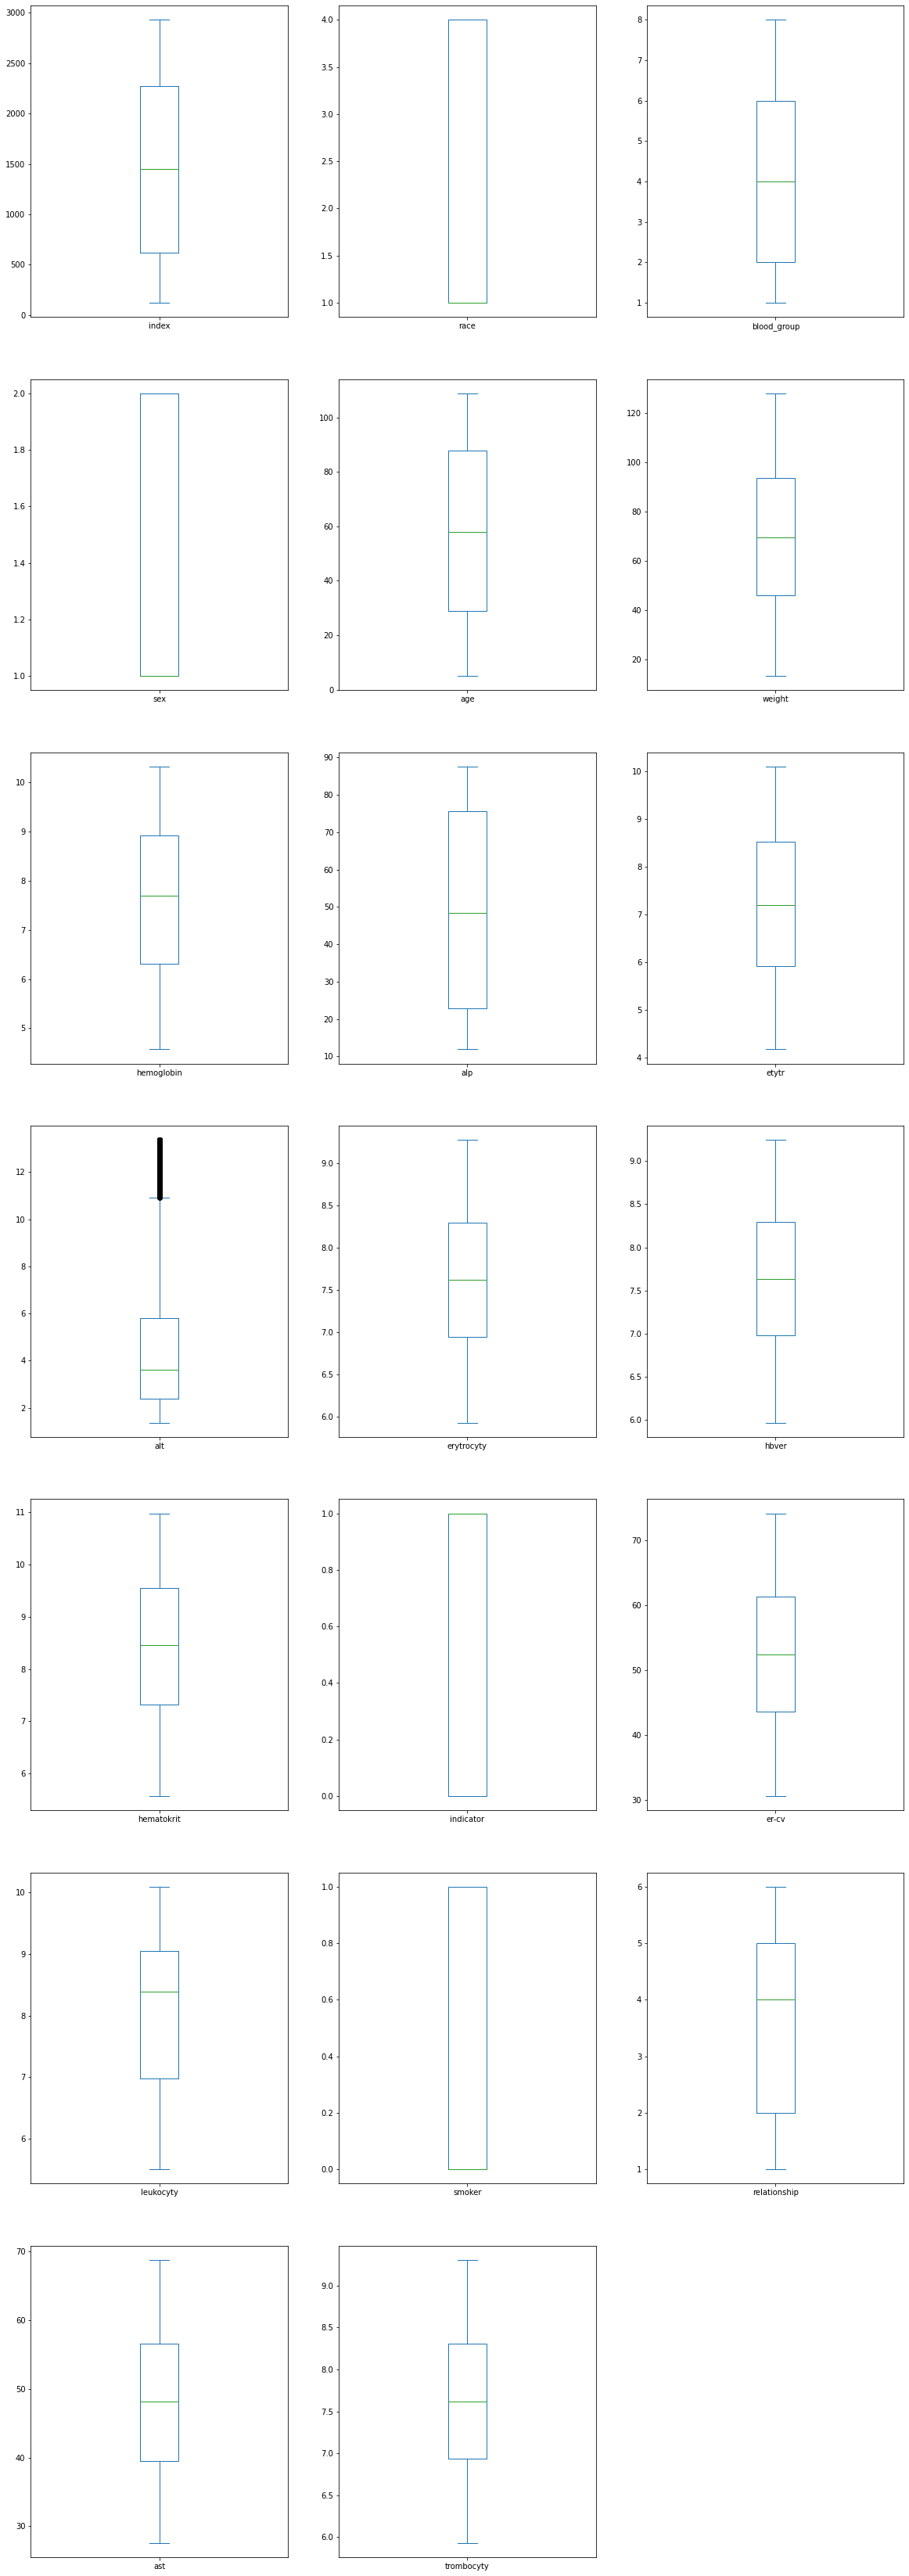

In [37]:
merged_mean_replacedOut.plot(kind='box', subplots=True, layout=(7, 3), sharex=False, sharey=False, figsize=(20, 60))

<AxesSubplot:>

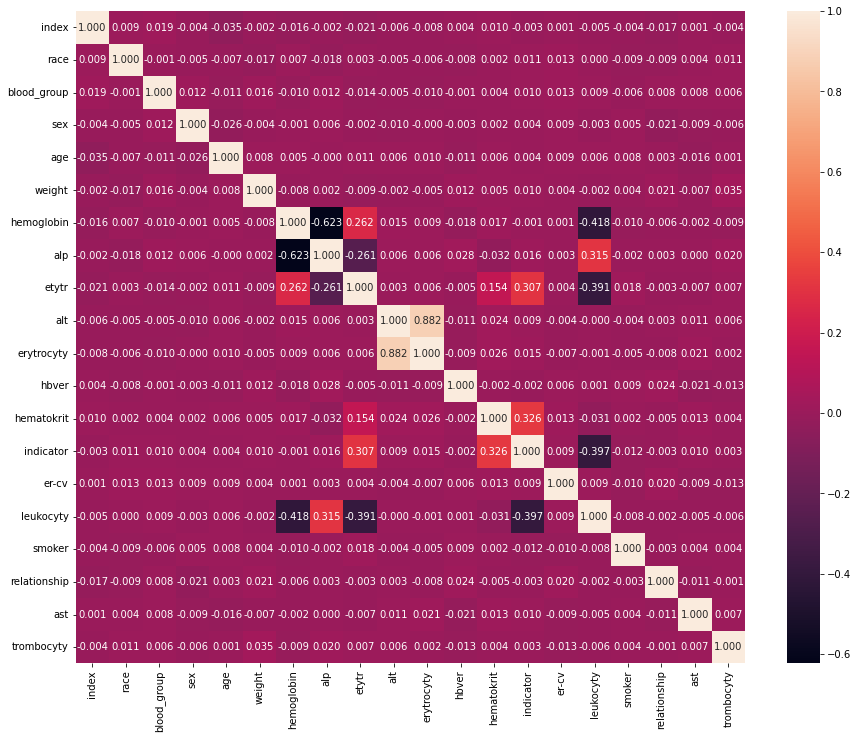

In [38]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(merged_mean_replacedOut.corr(), ax=ax, annot=True, fmt=".3f")

In [39]:
merged.corr() - merged_mean_replacedOut.corr()

,index,race,blood_group,sex,age,weight,hemoglobin,alp,etytr,alt,erytrocyty,hbver,hematokrit,indicator,er-cv,leukocyty,smoker,relationship,ast,trombocyty
index,0.000000,-0.002402,0.000448,-0.000895,0.000014,0.000786,-0.001245,0.000008,-0.005040,0.007573,0.000984,0.002811,-0.001349,-0.000128,-0.000244,-0.002555,-0.000777,-0.000010,-0.000505,-0.000023
race,-0.002402,0.000000,-0.005121,-0.001541,0.003180,-0.003696,-0.001979,-0.000507,0.001285,0.000143,0.000117,0.004529,0.002599,0.000541,0.002594,0.000799,-0.000054,0.000061,0.001196,0.002503
blood_group,0.000448,-0.005121,0.000000,0.000000,-0.000129,0.000559,0.000981,0.000177,0.000299,0.009585,0.002630,0.001237,0.000729,0.000000,0.000049,0.001162,0.000000,0.000000,0.000089,-0.001348
sex,-0.000895,-0.001541,0.000000,0.000000,0.000432,-0.000170,0.000874,0.000013,-0.001477,-0.007874,-0.002519,-0.000930,0.003825,0.000000,0.000049,0.000704,0.000000,0.000000,0.000325,0.000910
age,0.000014,0.003180,-0.000129,0.000432,0.000000,0.000567,-0.000046,-0.000439,0.001409,-0.008917,-0.001946,-0.004455,0.000006,-0.000174,0.002589,0.000842,0.000015,0.000188,-0.000582,-0.000043
weight,0.000786,-0.003696,0.000559,-0.000170,0.000567,0.000000,-0.000782,-0.001060,0.000190,0.001069,0.000851,-0.003786,0.000448,0.000585,-0.001615,0.002727,-0.000371,-0.001637,0.003584,-0.003668
hemoglobin,-0.001245,-0.001979,0.000981,0.000874,-0.000046,-0.000782,0.000000,0.066199,-0.002399,-0.006281,-0.000382,0.000877,0.004988,0.002675,-0.002086,0.008281,-0.002682,-0.000555,0.001799,0.002399
alp,0.000008,-0.000507,0.000177,0.000013,-0.000439,-0.001060,0.066199,0.000000,0.019227,0.006743,0.001725,-0.000621,0.005662,0.000432,0.001502,-0.004134,0.000403,0.000057,-0.000454,-0.000721
etytr,-0.005040,0.001285,0.000299,-0.001477,0.001409,0.000190,-0.002399,0.019227,0.000000,-0.013291,-0.002887,0.000393,0.018105,-0.006401,0.002214,0.035016,0.000465,-0.000785,-0.000896,0.000384
alt,0.007573,0.000143,0.009585,-0.007874,-0.008917,0.001069,-0.006281,0.006743,-0.013291,0.000000,-0.116270,-0.003172,-0.001153,-0.005792,0.007579,0.003120,0.013542,-0.006155,0.005617,-0.003745


# Ďalej budeme pracovať s dátami, kde boli chýbajúce dáta nahradené priemermi a outliery nahradené 5% alebo 95%???

## 2. Realizácia predspracovania dát (5b)


* Transformované dáta pre strojové učenie si rozdeľuje na trénovaciu a testovaciu množinu (train and test mergedset) podľa vami preddefinovaným pomerom. Naďalej pracujte len s trénovacím mergedsetom.
* Transformujte atribútov dát pre strojové učenie podľa dostupných techník (minimálne 2 techniky) ako scaling, transformers a ďalšie.
* Zdôvodnite Vašu voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)

## 3. Výber atribútov pre strojové učenie (5b)

* Zistite ktoré atribúty (features) vo vašich dátach pre strojové učenie sú informatívne k atribútu “indikator”. Zoradíte tie atribúty v poradí podľa dôležitosti. 
* Zdôvodnite Vašu voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)

## 4. Replikovateľnosť predspracovania (5b)

* Upravte váš kód realizujúci predspracovanie trénovacej množiny tak, aby ho bolo možné bez ďalších úprav znovu použiť na predspracovanie testovacej množiny (napr. pomocou funkcie/í)
* Očakáva sa aj využitie možnosti sklearn.pipeline

Správa sa odovzdáva v 9. týždni semestra

Na cvičení, dvojica svojmu cvičiacemu odprezentuje vykonanú prieskumnú analýzu v Jupyter Notebooku.
Správu elektronicky odovzdá jeden člen z dvojice do systému AIS do nedele 21.11.2021 23:59.